## Détermination de groupes de codes postaux

#### Idée
 les codes postaux ont été anonymisés, ils constituent donc une boîte noire que l'on ne peut pas utiliser telle quelle. <br/>Par contre, on peut supposer que certains types de vêtements associés à un type de climat (shorts, manteaux) n'ont pas les mêmes figures de ventes selon la zone géographique et éventuellement l'hémisphère.<br/>-> Nous allons donc tenter de déterminer des groupes de codes postaux.
#### Features à contruire 
- Différentiel entre le minimum et le maximum de ventes pour chaque type de produit
- Pic de vente pour chaque type de produit.

In [1]:
import pandas as pd
import numpy as np

### Création des features

In [2]:
transactions = pd.read_pickle('pickles/transactions_clean.pkl')

In [4]:
transactions.drop(columns = ['t_dat', 'price', 'sales_channel_id', 'quantity'], axis = 1, inplace = True)

In [5]:
# Aggrégation des ventes par client / période dans un premier temps
sales_by_week = transactions.groupby(['week_number', 'customer_id', 'article_id'], as_index = False).agg(
    sales = ('article_id', 'count')
)

In [ ]:
# Ajout des codes postaux
postal_codes = pd.read_pickle('pickles/customers_clean.pkl')
postal_codes = postal_codes[['customer_id', 'postal_code']]

sales_by_week = sales_by_week.merge(postal_codes, on = 'customer_id', how = 'left')

sales_by_week.postal_code = sales_by_week.postal_code.astype(str)

In [13]:
# Aggrégation par code postal
sales_by_postal_code = sales_by_week.groupby(['article_id', 'week_number', 'postal_code'], as_index = False).agg(
    sales = ('sales', 'sum')
)

In [14]:
# Sauvegarde pour utilisation ultérieure.
sales_by_postal_code.to_pickle('pickles/sales_by_postal_code.pkl')

In [2]:
# Ajout du type de produit
articles = pd.read_pickle('pickles/articles_clean.pkl')
sales_by_postal_code = pd.read_pickle('pickles/sales_by_postal_code.pkl')

articles = articles[['article_id', 'product_type_name']]
sales_by_postal_code = sales_by_postal_code.merge(articles, how = 'left', on = 'article_id')

sales_by_postal_code.product_type_name = sales_by_postal_code.product_type_name.astype(str)

In [3]:
# Aggrégation par type de produit.
sales_by_product_type = sales_by_postal_code.groupby(['week_number', 'postal_code', 'product_type_name'], as_index = False).agg(
    sales = ('sales', 'sum')
)

In [4]:
# Sauvegarde pour utilisation ultérieure.
sales_by_product_type.to_pickle('pickles/sales_by_postal_codes_product_type.pkl')

In [5]:
# Calculer le minimum et le maximum de vente sur la période, pour chaque catégorie et code postal.
sales_category_boundaries = sales_by_product_type.groupby(['postal_code', 'product_type_name'], as_index = False).agg(
    sales_min = ('sales', 'min'),
    sales_max = ('sales', 'max'),
    max_index = ('sales', 'idxmax')
)

In [12]:
# Ajout du numéro de semaine où les ventes on été maximales.
week_number_max = sales_by_product_type.loc[sales_category_boundaries['max_index']]['week_number']
sales_category_boundaries['week_number_max'] = week_number_max.reset_index()['week_number']

sales_category_boundaries.drop(columns = 'max_index', axis = 1, inplace = True)

In [13]:
# Sauvegarde pour utilisation ultérieure.
sales_category_boundaries.to_pickle('pickles/sales_postal_codes_category_boundaries.pkl')
sales_category_boundaries.head()

,postal_code,product_type_name,sales_min,sales_max,week_number_max
0,0000198d2c593b7d3df5a35282b74cf3a487b066286b2b...,Blouse,1,1,8
1,0000198d2c593b7d3df5a35282b74cf3a487b066286b2b...,Bra,1,1,18
2,0000198d2c593b7d3df5a35282b74cf3a487b066286b2b...,Other accessories,2,2,86
3,0000198d2c593b7d3df5a35282b74cf3a487b066286b2b...,Sunglasses,1,1,18
4,0000198d2c593b7d3df5a35282b74cf3a487b066286b2b...,Sweater,2,2,86


In [14]:
### Création d'un tableau avec les ventes des chaque catégorie en ligne. ###
postal_codes = pd.DataFrame()

postal_codes['postal_code'] = sales_category_boundaries['postal_code'].unique()
product_types = sales_category_boundaries['product_type_name'].sort_values().unique()

# On n'utilisera qu'un certain nombre de produits dont nous pensons que les ventes sont liées au climat local.
product_types_kept = ['Bikini top', 'Blanket', 'Coat', 'Gloves', 'Hoodie',
       'Jacket','Scarf', 'Shorts', 'Sunglasses', 'Sweater', 'Swimwear bottom',
       'Swimwear set', 'Swimwear top', 'Umbrella']

for product_type in product_types_kept:
    prefix = f"{product_type}".lower()
    
    product_type_feats = sales_category_boundaries[sales_category_boundaries['product_type_name'] == product_type]
    product_type_feats = product_type_feats.rename({
        'sales_min': f'{prefix}_min',
        'sales_max': f'{prefix}_max',
        'week_number_max': f'{prefix}_peak',
    }, axis = 1).drop(columns = 'product_type_name', axis = 1)
    
    postal_codes = postal_codes.merge(product_type_feats, on = 'postal_code', how = 'left')
    
postal_codes.fillna(0, inplace = True)

In [18]:
# Sauvegarde.
postal_codes.to_pickle('pickles/postal_codes_features.pkl')
postal_codes.head()
    

,postal_code,bikini top_min,bikini top_max,bikini top_peak,blanket_min,blanket_max,blanket_peak,coat_min,coat_max,coat_peak,...,swimwear bottom_peak,swimwear set_min,swimwear set_max,swimwear set_peak,swimwear top_min,swimwear top_max,swimwear top_peak,umbrella_min,umbrella_max,umbrella_peak
0,0000198d2c593b7d3df5a35282b74cf3a487b066286b2b...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00005652fb5323679a5d608ce8c94fbb57bc15d3d8c01a...,1.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0000eda740da878fb9df474806be9597f043eb5f748091...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0001617618d0facf2ae73cdba7b8caefb3c05e6987a98a...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00016f13cb796865b053cda4d470b4a3146553eaa36241...,1.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Normalization et réduction de dimension
Voir le code de `preparing_postal_code_features.py`

### Lancement du modèle

In [2]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from utils.map12_from_series import map12_from_series

postal_codes = pd.read_pickle('pickles/postal_codes_features')
feats = postal_codes.drop(columns = 'postal_code', axis = 1).fillna(0).astype(int)

pca = PCA(n_components=0.95)
scaler = MinMaxScaler()     

pipeline = Pipeline(steps = [
    ('scaler', scaler),
    ('pca', pca),                       
])

postal_codes = pd.read_pickle('pickles/postal_codes_features.pkl')

In [4]:
# Utilisation des ventes de la dernière semaine pour score la clusterisation.
transactions = pd.read_pickle('pickles/transactions_clean.pkl')
customers = pd.read_pickle('pickles/customers_clean.pkl')

customers['postal_code'] = customers['postal_code'].astype('str')

last_week_sales = transactions[transactions['week_number'] == 0]
last_week_sales = last_week_sales.merge(customers[['customer_id', 'postal_code']], on = 'customer_id', how = 'left')

validation_data = last_week_sales.groupby(['customer_id', 'postal_code'], as_index = False).agg(
    purchased_articles = ('article_id', lambda x: list(x))
)

In [6]:
# Calculer le score MAP@12 de la liste des articles les plus populaires, comme point de comparaison
top_sales_list = last_week_sales.groupby('article_id', as_index = False).agg(
    sales = ('article_id', 'count')
).nlargest(12, 'sales')['article_id'].to_list()

top_sales = validation_data[['purchased_articles']]
top_sales.loc[:, 'prediction'] = [top_sales_list] * len(top_sales)

top_sales_score = map12_from_series(top_sales['purchased_articles'], top_sales['prediction']).sum() / len(top_sales)
print("Score des articles les plus populaires: ", top_sales_score)

/home/treb/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Score des articles les plus populaires:  0.010255633264301744


### Recherche de la meilleure clusterisation
#### 1. Sans features polynomiales

In [7]:
X = pipeline.fit_transform(feats)

In [ ]:
# Recherche du nombre de clusters qui donnera le meilleur score MAP@12
score_curve = [top_sales_score] 
best_score = 0

for k in range(2, 10):
    
    print(f"\r Entraînement pour {k} clusters                    ", end="")
    model = KMeans(n_clusters=k).fit(X)
    clusters = model.predict(X)
    
    # Process a top sales list for each groups.
    postal_codes_groups = postal_codes[['postal_code']]
    postal_codes_groups.loc[:, 'group'] = clusters
    
    top_sales_by_group = last_week_sales.merge(postal_codes_groups, on ='postal_code', how='left').groupby(
        ['group', 'article_id'],
        as_index = False
    ).agg(
        sales = ('article_id', 'count')
    )
    
    print(f"\r Mise en forme des données                   ", end="")
    
    # Assign the lists to each postal code
    top_sales_lists = {}
    for group in range(0, k + 1):
        top_sales_lists[group] = top_sales_by_group.loc[top_sales_by_group['group'] == group].nlargest(12, columns = ['sales'])['article_id'].to_list()
    
    postal_codes_groups.loc[:, 'prediction'] = postal_codes_groups.loc[:, 'group'].apply(lambda x: top_sales_lists[x])
    
    # Put the prediction aside of the real lists.
    validation_data_with_prediction = validation_data.merge(postal_codes_groups, on = 'postal_code', how='left')
    
    print(f"\r Calcul du score pour {k} clusters                 ", end="")
    score = map12_from_series(validation_data_with_prediction['purchased_articles'], validation_data_with_prediction['prediction']).sum() / len(validation_data_with_prediction)
    
    print(f"Score pour {k} clusters: {score}")
    
    if score > best_score:
        best_model = model
        best_clusters = clusters
        
    score_curve.append(score)

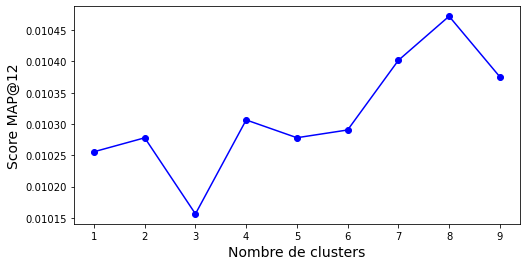

: 

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), score_curve, "bo-")
plt.xlabel("Nombre de clusters", fontsize=14)
plt.ylabel("Score MAP@12", fontsize=14)
plt.show()

#### 2. Avec features polynomiales

In [4]:
# Ajout des features polynomiales

polynomial_features = PolynomialFeatures(degree=2)
X = pca.fit_transform(feats)
X = polynomial_features.fit_transform(X)
X = pca.fit_transform(X)
X = scaler.fit_transform(X)

In [5]:
# Partons sur 8 groupes.
 
kmeans = KMeans(n_clusters=8)
clusters = kmeans.fit_predict(X)

In [14]:
### Calcul du score

# Process a top sales list for each groups.
postal_codes_groups = postal_codes[['postal_code']]
postal_codes_groups.loc[:, 'group'] = clusters

top_sales_by_group = last_week_sales.merge(postal_codes_groups, on ='postal_code', how='left').groupby(
    ['group', 'article_id'],
    as_index = False
).agg(
    sales = ('sales', 'sum')
)

# Assign the lists to each postal code
top_sales_lists = {}
for group in range(0, 9):
    top_sales_lists[group] = top_sales_by_group.loc[top_sales_by_group['group'] == group].nlargest(12, columns = ['sales'])['article_id'].to_list()

postal_codes_groups.loc[:, 'prediction'] = postal_codes_groups.loc[:, 'group'].apply(lambda x: top_sales_lists[x])

# Put the prediction aside of the real lists.
validation_data_with_prediction = validation_data.merge(postal_codes_groups, on = 'postal_code', how='left')

score = map12_from_series(validation_data_with_prediction['purchased_articles'], validation_data_with_prediction['prediction']).sum() / len(validation_data_with_prediction)

print("Score pour 8 clusters et features polynomiales:", score)

Score pour 8 clusters et features polynomiales: 0.010348885434011204


In [7]:
postal_codes_groups.to_pickle("pickles/postal_code_groups.pkl")

### Groupage par corrélation entre les figures de ventes
Nous allons maintenant dresser un tableau des ventes par articles par code postal sur l'avant-dernière semaine, et allons tenter de déterminer des corrélations.

In [ ]:
### Génération du tableau des ventes.
sales_by_postal_code = pd.read_pickle('pickles/sales_by_postal_code.pkl')
sales_by_postal_code = sales_by_postal_code[sales_by_postal_code['week_number'] == 1]

postal_codes_list = sales_by_postal_code['postal_code'].unique()

article_ids = sales_by_postal_code['article_id'].unique()
sales_board = pd.DataFrame({'article_id': article_ids})

for i in range(len(postal_codes_list)):
    print(f"\rTraitement du code postal n°{i} / {len(postal_codes_list)}", end = "")
    
    sales_to_merge = sales_by_postal_code[sales_by_postal_code['postal_code'] == postal_code][['article_id', 'sales']].rename({'sales' : postal_code}, axis = 1)
    
    sales_board = sales_board.merge(sales_to_merge, on = 'article_id', how = 'left')
    
sales_board.fillna(0, inplace=True)
sales_board.set_index('article_id', inplace = True)
sales_board.head(8)

In [ ]:
### Groupage par niveau de corrélation

# Calcul de la matrice de corrélation
corr = sales_board.corr()

# 
chunks = []

#### Conclusion
Le groupage par code postal semble amener un petit plus, mais très faible.